number of train observations is 25000
number of test observations is 25000
number of train observations is 25000
number of test observations is 25000
<class 'numpy.ndarray'>
<class 'list'>
218
189
[1, 14, 22, 16, 43]
train ids range from 1 to 9999
0    12500
1    12500
dtype: int64
0    12500
1    12500
dtype: int64
19
1
the
2
and
3
a
4
of
5
to
6
is
7
br
8
in
9
it
10
i
11
this
12
that
13
was
14
as
15
for
16
with
17
movie
18
but
19
film
20
on
(30989, 'bathos')
(66877, 'secondus')
(26105, 'wheeling')
(55425, "lynn's")
(3632, 'twin')
(80629, 'scalped')
(23995, 'cycles')
(30513, 'withdraws')
(29055, 'particle')
(65683, 'nixon”')
? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and ? romance ? on to the scene ? ? the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made ? was obviously shot on a low budget but this is made up for in far

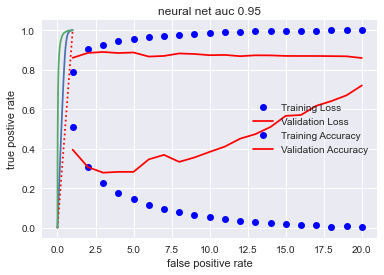

In [2]:
## imports

##basic
import numpy as np
import pandas as pd
import math

## graphics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

## sklearn
from sklearn.preprocessing import StandardScaler

## keras
from tensorflow import keras

import tensorflow as tf

import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

##roc/auc
from sklearn.metrics import roc_auc_score
## note online sklearn seemed to have plot_roc_curve, but I just found this one
##   I probably need to update my system!!
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

## lift curve
def mylift(y,p):
   """lift"""
   ii = np.argsort(p)[::-1]
   ps = np.cumsum(y[ii])/np.sum(y)
   return(ps)


##################################################

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=10000)
  ## this generated warnings about Creating an ndarray from ragged nested sequences
print(f'number of train observations is {len(train_labels)}')
print(f'number of test observations is {len(test_labels)}')
print(f'number of train observations is {len(train_data)}')
print(f'number of test observations is {len(test_data)}')

## data is a ndarray of lists, each list as the ids for words in the document.
##  see above note about the warning.
print(type(train_data))
print(type(train_data[0]))
print(len(train_data[0]))
print(len(train_data[1]))

## ids of first 5 words in first train obs
print(train_data[0][:5])

MM = max([max(sequence) for sequence in train_data])
LL = min([min(sequence) for sequence in train_data])
print(f'train ids range from {LL} to {MM}')

## labels are 0,1 binary, 1 is positive
train_labels.dtype

## tables for binary y, train and test, this data is cooked so that the 0's and 1's are balanced.
print(pd.Series(train_labels).value_counts())
print(pd.Series(test_labels).value_counts())


##################################################
### pg 69 , for fun get word names

## word_index is a dict with keys = text of words and values = integer indices
word_index = keras.datasets.imdb.get_word_index()
print(word_index['film'])

# flip key and value(key, value) -> (value,key)
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

## first words
for i in range(1,21):
   print(i)
   print(reverse_word_index[i])

## randomly sampled words
nw = len(word_index)
np.random.seed(34) 
nd = 10
indices = np.random.choice(nw,nd,replace=False)
for i in indices:
   print((i,reverse_word_index[i]))

rid = 10 # review id to translate to words
decoded_review = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[rid]])
print(decoded_review)

## just print out the first nw words from the review
rid = 10 # review id to translate to words
nw = 15
for i in range(1,nw):
   wid = train_data[rid][i]
   print(wid,reverse_word_index[wid-3]) #offset of 3

##################################################
### preparing the data

def vseq(seq,dim=10000):
   res = np.zeros((len(seq),dim))
   for i, s in enumerate(seq):
      res[i,s] = 1
   return res

xtr = vseq(train_data)
xte = vseq(test_data)

## check
rid =  0
print(f'num = 1 in rev {rid} is {xtr[rid].sum()}')
print(f'number unique id in rev is {len(pd.Series(train_data[rid]).unique())}')

## labels as float32 arrays
ytr = np.asarray(train_labels).astype('float32')
yte = np.asarray(test_labels).astype('float32')
print(pd.Series(ytr).value_counts())
print(pd.Series(yte).value_counts())

##################################################
## pg 70 Building your network

model = keras.models.Sequential()

model.add(keras.layers.Dense(16,activation='relu',input_shape=(xtr.shape[1],)))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

## split train into "partial train" and val

nval = 10000

xval = xtr[:nval]
yval = ytr[:nval]

pxtr = xtr[nval:]
pytr = ytr[nval:]

# train and store history in trh 
trh = model.fit(pxtr,pytr,epochs=20,batch_size=512,validation_data=(xval,yval))

##################################################
### plot history pg 74

hdict = trh.history
type(hdict)
hdict.keys()

## loss
trL = hdict['loss']
teL = hdict['val_loss']
eind = range(1,len(trL)+1) 

plt.plot(eind,trL,'bo',label='Training Loss')
plt.plot(eind,teL,'r',label='Validation Loss')
plt.title('loss vs epoch')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend(loc=9)
fig = plt.gcf()
fig.savefig('training_imdb.pdf')

## accuracy
trA = hdict['accuracy']
teA = hdict['val_accuracy']

plt.plot(eind,trA,'bo',label='Training Accuracy')
plt.plot(eind,teA,'r',label='Validation Accuracy')
plt.title('accuracy vs epoch')
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.legend()
fig = plt.gcf()
fig.savefig('training_imdb_acc.pdf')

##################################################
## refit on train using just 4 epochs, predict on test

mod = keras.models.Sequential()

mod.add(keras.layers.Dense(16,activation='relu',input_shape=(xtr.shape[1],)))
mod.add(keras.layers.Dense(16,activation='relu'))
mod.add(keras.layers.Dense(1,activation='sigmoid'))

mod.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc']) #?short name for acc?


# train on all the train 
nepoch = 4
mod.fit(xtr,ytr,epochs=nepoch,batch_size=512)
# not evaluate on test data
res = mod.evaluate(xte,yte)
print(res)

##################################################
### predict

phat = mod.predict(xte)
print(type(phat))
print(phat.shape)
phat = phat.squeeze()
print(phat.shape)

nte = len(yte)
ypred = np.zeros((nte,))
ypred[phat>.5]=1
cTab = pd.crosstab(yte,ypred)

##check test accuracy
np.diag(cTab.to_numpy()).sum()/nte
print(cTab)


## plot lift curve
plt.plot((np.arange(nte)+1)/nte,mylift(yte,phat))
plt.title('out-of-sample lift curve')
plt.plot((np.arange(nte)+1)/nte,(np.arange(nte)+1)/nte,c='red',linestyle='dotted')
plt.xlabel('percent test data'); plt.ylabel('percent test 1 found')
fig = plt.gcf()
fig.savefig("test-lift_imbd.pdf")

##auc
aucnn = roc_auc_score(yte,phat)
print('auc for neural net: ',aucnn)

##roc
rocnn = roc_curve(yte,phat)
plt.plot(rocnn[0],rocnn[1])
plt.xlabel('false positive rate'); plt.ylabel('true postive rate')
plt.title('neural net auc ' + str(np.round(aucnn,2)))
fig = plt.gcf()
fig.savefig("test-roc_imbd.pdf")

## does not work, probably because mod.predict gives phat matrix, not ypred
#plot_roc_curve(mod,xte,yte)
